## Note
Trying out different models and paramaters to see which performs the best

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Loading the evaluation data
df = pd.read_csv("../csv_files/development.csv")

In [3]:
# Extracting the positions, removes the x and y column and splitting the data into train and validation set
def extraxting_positions(df):
    pos = []
    for i in range(len(df)):
        pos.append([df["x"].iloc[i], df["y"].iloc[i]])
    return pos

pos = extraxting_positions(df)

## Dropping data from x and y 
df.drop(["x", "y"], axis=1, inplace=True)


In [4]:
## Removing pads with format: pads = ["0", "7", "12", ..]
def drop_pads(df, pads):
    cols_to_drop = [col for col in df.columns if any(idx in col for idx in pads)]
    df_removed = df.drop(cols_to_drop, axis=1)    
    return df_removed

remove_pads = ["0", "7", "12", "15", "16", "17"]
df_removed_noise = drop_pads(df, remove_pads)

In [5]:
## Splitting into train and validation set
X_train, X_val, pos_train, pos_val = train_test_split(df_removed_noise, pos, test_size=0.2, random_state=42)

In [6]:
# RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
numb_trees = 10
base_regressor = RandomForestRegressor(n_estimators=numb_trees) 

mult_regr = MultiOutputRegressor(base_regressor)
mult_regr.fit(X_train, pos_train)
pos_pred = mult_regr.predict(X_val)

KeyboardInterrupt: 

In [ ]:
# Metrics to evaluating model 
import sklearn.metrics as sm
import math
import numpy as np

def avg_euc_dist(pos_val, pos_pred):
    sum_square = 0
    for i in range(len(pos_val)):
        sum_square += math.sqrt((pos_val[i][0]-pos_pred[i][0])**2 + (pos_val[i][1]-pos_pred[i][1])**2)
    return sum_square/len(pos_val)        

def metrics_on_model(pos_val, pos_pred):
    print("Mean absolute error =", round(sm.mean_absolute_error(pos_val, pos_pred), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(pos_val, pos_pred), 2)) 
    print("Median absolute error =", round(sm.median_absolute_error(pos_val, pos_pred), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(pos_val, pos_pred), 2)) 
    print("R2 score =", round(sm.r2_score(pos_val, pos_pred), 2))
    print("Mean eucledian distance =", round(avg_euc_dist(pos_val, pos_pred), 2))

#metrics_on_model(pos_val, pos_pred)

## Using the multiple_reg_model on the evaluation set

In [ ]:
ev_data = pd.read_csv("../csv_files/evaluation.csv")

In [ ]:
# Extracting the ID
eval_id = ev_data["Id"]

# Dropping the Id column from the ev_data
ev_data.drop(["Id"], axis=1, inplace=True)

In [ ]:
# Formatting the position array to a string to be used in the .csv file 
def pred_to_string(prediction_array):
    pred_column = []
    for i in range(len(prediction_array)):
        pos_string = (str(prediction_array[i][0]) + "|" + str(prediction_array[i][1]))
        pred_column.append(pos_string)
    return pred_column
        

In [ ]:
# Predicting the evaluation results
mult_regr_eval = mult_regr.predict(ev_data)
pos_pred = pred_to_string(mult_regr_eval) # Formatting the predictions 

In [ ]:
# Creating a df and .csv file to be submitted. Saved in submission_file folder
mult_reg_submission = pd.DataFrame({'Id': eval_id, 'Predicted': pos_pred})
mult_reg_submission.to_csv("../DataScienceLab_Project/submission_files/mult_reg_first_try.csv", index=False)

## Gradient Boost

In [ ]:

# instantiate multi output gradient boost model
GBR = GradientBoostingRegressor(n_estimators=60)
gbr_model = MultiOutputRegressor(GBR)

# Train, test and eval
gbr_model.fit(X_train, pos_train)


MultiOutputRegressor(estimator=GradientBoostingRegressor(n_estimators=60))

In [ ]:
# test and eval metrics
pred = gbr_model.predict(X_val)
metrics_on_model(pos_val, pred)


Mean absolute error = 10.01
Mean squared error = 178.59
Median absolute error = 7.96
Explain variance score = 0.99
R2 score = 0.99
Mean eucledian distance = 15.75


In [ ]:
# make submission
# Predicting the evaluation results
sub_pred = gbr_model.predict(ev_data)
pos_pred = pred_to_string(sub_pred) # Formatting the predictions 
GBR_submission = pd.DataFrame({'Id': eval_id, 'Predicted': pred})
GBR_submission.to_csv("../DataScienceLab_Project/submission_files/GBR.csv", index=False)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- area[0]
- area[10]
- area[12]
- area[15]
- area[16]
- ...


## NN

In [ ]:
from sklearn.neural_network import MLPRegressor

NN_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500)



In [ ]:
NN_model.fit(X_train, pos_train)


MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500)

In [ ]:
# Make predictions on the test set
predictions = NN_model.predict(X_val)

# Evaluate the performance
metrics_on_model(pos_val, predictions)

Mean absolute error = 32.9
Mean squared error = 8585.68
Median absolute error = 11.69
Explain variance score = 0.42
R2 score = 0.35
Mean eucledian distance = 47.76


In [ ]:
log_NN_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500)

In [ ]:
X_train.columns

Index(['pmax[1]', 'negpmax[1]', 'area[1]', 'tmax[1]', 'rms[1]', 'pmax[2]',
       'negpmax[2]', 'area[2]', 'tmax[2]', 'rms[2]', 'pmax[3]', 'negpmax[3]',
       'area[3]', 'tmax[3]', 'rms[3]', 'pmax[4]', 'negpmax[4]', 'area[4]',
       'tmax[4]', 'rms[4]', 'pmax[5]', 'negpmax[5]', 'area[5]', 'tmax[5]',
       'rms[5]', 'pmax[6]', 'negpmax[6]', 'area[6]', 'tmax[6]', 'rms[6]',
       'pmax[8]', 'negpmax[8]', 'area[8]', 'tmax[8]', 'rms[8]', 'pmax[9]',
       'negpmax[9]', 'area[9]', 'tmax[9]', 'rms[9]', 'pmax[11]', 'negpmax[11]',
       'area[11]', 'tmax[11]', 'rms[11]', 'pmax[13]', 'negpmax[13]',
       'area[13]', 'tmax[13]', 'rms[13]', 'pmax[14]', 'negpmax[14]',
       'area[14]', 'tmax[14]', 'rms[14]'],
      dtype='object')

In [ ]:
log_X_train = np.abs(X_train)
log_X_train = np.log1p(log_X_train)
log_NN_model.fit(log_X_train, pos_train)

/Users/louislinnerud/Documents/skole/4.klasse/7.semester/Data science lab/semesteroppgave/DSLvenv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500)

In [ ]:
# Make predictions on the test set
log_X_val = np.abs(X_val)
log_X_val = np.log1p(log_X_val)
predictions = NN_model.predict(log_X_val)

# Evaluate the performance
metrics_on_model(pos_val, predictions)

Mean absolute error = 362.78
Mean squared error = 144643.05
Median absolute error = 362.26
Explain variance score = 0.05
R2 score = -9.55
Mean eucledian distance = 525.29


# Model interpretations

/var/folders/g6/8s3y92xd79nfwz0gth0f3tr00000gn/T/ipykernel_1076/2320970504.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance, y=sorted_feature_names, orient='h', palette="viridis")


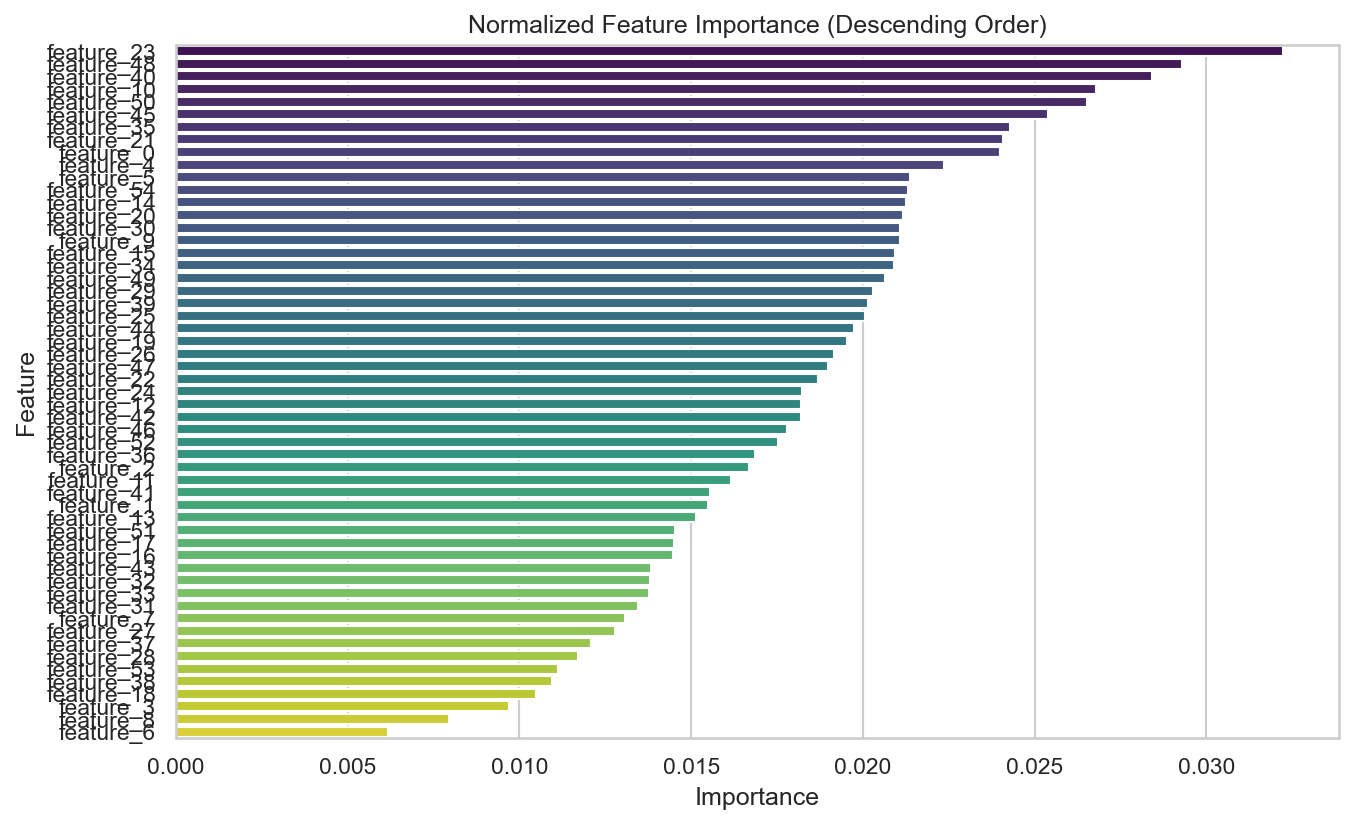

In [ ]:
# Get the weights of the input layer
input_layer_weights = NN_model.coefs_[0]
# Calculate the absolute sum of weights for each feature
feature_importance = np.sum(np.abs(input_layer_weights), axis=1)

# Normalize the importance scores
normalized_importance = feature_importance / np.sum(feature_importance)

# Sort features in descending order
sorted_indices = np.argsort(normalized_importance)[::-1]
sorted_importance = normalized_importance[sorted_indices]
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

sorted_feature_names = np.array(feature_names)[sorted_indices]

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6), dpi=150)
sns.barplot(x=sorted_importance, y=sorted_feature_names, orient='h', palette="viridis")
plt.title('Normalized Feature Importance (Descending Order)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Explaination for #feature xx"
idx = 1
for col_name in X_train.columns:
    print(f"{idx}, {col_name}")
    idx +=1

1, pmax[1]
2, negpmax[1]
3, area[1]
4, tmax[1]
5, rms[1]
6, pmax[2]
7, negpmax[2]
8, area[2]
9, tmax[2]
10, rms[2]
11, pmax[3]
12, negpmax[3]
13, area[3]
14, tmax[3]
15, rms[3]
16, pmax[4]
17, negpmax[4]
18, area[4]
19, tmax[4]
20, rms[4]
21, pmax[5]
22, negpmax[5]
23, area[5]
24, tmax[5]
25, rms[5]
26, pmax[6]
27, negpmax[6]
28, area[6]
29, tmax[6]
30, rms[6]
31, pmax[8]
32, negpmax[8]
33, area[8]
34, tmax[8]
35, rms[8]
36, pmax[9]
37, negpmax[9]
38, area[9]
39, tmax[9]
40, rms[9]
41, pmax[11]
42, negpmax[11]
43, area[11]
44, tmax[11]
45, rms[11]
46, pmax[13]
47, negpmax[13]
48, area[13]
49, tmax[13]
50, rms[13]
51, pmax[14]
52, negpmax[14]
53, area[14]
54, tmax[14]
55, rms[14]
